# Анализ лояльности пользователей Яндекс Афиши

Выполнил: Садыков Артём

Дата начала: 9.11.2025

### Цель 
Команда маркетинга хочет лучше понимать поведение пользователей. Для этого они просят нас провести исследовательский анализ данных, чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно. В переспективе это позволит:
- Быстро выявлять перспективных клиентов и предлагать им персонализированные условия.
- Точно настраивать рекламу на аудитории с высокой вероятностью возврата.
- Оптимизировать маркетинговые бюджеты.
- Повысить общий уровень удержания клиентов.

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [2]:
!pip install sqlalchemy

In [3]:
!pip install psycopg2

     |████████████████████████████████| 379 kB 2.4 MB/s eta 0:00:01
    ERROR: Command errored out with exit status 1:
     command: /opt/conda/bin/python3.9 -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-f81nxh6y/psycopg2_69ae578ca0b54a1190ec4e5adb35e048/setup.py'"'"'; __file__='"'"'/tmp/pip-install-f81nxh6y/psycopg2_69ae578ca0b54a1190ec4e5adb35e048/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-pip-egg-info-hpavxa01
         cwd: /tmp/pip-install-f81nxh6y/psycopg2_69ae578ca0b54a1190ec4e5adb35e048/
    Complete output (23 lines):
    running egg_info
    creating /tmp/pip-pip-egg-info-hpavxa01/psycopg2.egg-info
    writing /tmp/pip-pip-egg-info-hpavxa01/psycopg2.egg-info/PKG-INFO
    writing dependen

In [4]:
import pandas as pd
from sqlalchemy import create_engine 
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
!pip install phik

     |████████████████████████████████| 677 kB 1.7 MB/s eta 0:00:01


In [6]:
from phik import phik_matrix

In [7]:
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             } 

In [8]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [9]:
engine = create_engine(connection_string)


In [10]:
query = '''
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)

-- Напишите ваш запрос ниже
select user_id, device_type_canonical, order_id, created_dt_msk as order_dt, created_ts_msk as order_ts, currency_code, revenue, tickets_count,
(created_ts_msk::DATE-LAG(created_dt_msk::DATE) OVER (
    partition by user_id
    order by created_dt_msk::DATE)) as days_since_prev, p.event_id, event_name_code as event_name, event_type_main, service_name, r.region_name, c.city_name
from afisha.purchases as p
inner join afisha.events as e on p.event_id = e.event_id
inner join afisha.city as c on e.city_id = c.city_id
inner join afisha.regions as r on c.region_id = r.region_id 
where (device_type_canonical IN ('mobile','desktop')) and (event_type_main !='фильм')
order by user_id
'''

In [11]:
df = pd.read_sql_query(query, con=engine)
print(df)

                user_id device_type_canonical  order_id   order_dt  \
0       0002849b70a3ce2                mobile   4359165 2024-08-20   
1       0005ca5e93f2cf4                mobile   7965605 2024-07-23   
2       0005ca5e93f2cf4                mobile   7292370 2024-10-06   
3       000898990054619                mobile   1139875 2024-07-13   
4       000898990054619                mobile    972400 2024-10-04   
...                 ...                   ...       ...        ...   
290606  fffcd3dde79eb2c                mobile    368562 2024-10-27   
290607  fffcd3dde79eb2c                mobile    368591 2024-10-27   
290608  fffcd3dde79eb2c               desktop   8473772 2024-10-30   
290609  fffeeb3c120cf0b               desktop   5526067 2024-09-24   
290610  ffff00725179321                mobile    813654 2024-09-25   

                  order_ts currency_code  revenue  tickets_count  \
0      2024-08-20 16:08:03           rub  1521.94              4   
1      2024-07-23 18:36

In [12]:
# Выводим названия столбцов датафрейма df
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

Всего 290611 строк данных в 15 столбцах.Пропусков в загруженных данных практически - нет, поскольку мы ранее использовали тип присоединения inner join. в столбце days_since_prev имеются отсутвующие значения, но это было сделано намеренно, значит это были первые заказы. Все типы данных соответствуют хранящимся данным хранимым в стобцах. Названия столбцов соответствует стилистике змеиного языка. 

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [14]:
# читаем csv с курсом валют
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [15]:
# Знакомимся с содержимым:
tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [16]:
tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


курс представлен: датой, номиналом, собственно стоимостью 100 тенге в рублях и обозначением валюты. Чтобы произвести объединение и пересчет курса - необходимо перевести дату в формат даты а не объекта

In [17]:
tenge_df['data'] = pd.to_datetime(tenge_df['data'])

In [18]:
## присоединим информацию из курса валют к таблице для дальнейшего пересчета
df = df.merge(tenge_df, left_on=['order_dt', 'currency_code'], right_on=['data', 'cdx'], how='left')

In [19]:
## проверим правильность присоединения
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,data,nominal,curs,cdx
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,NaT,NaN,NaN,NaN
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,NaT,NaN,NaN,NaN
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,NaT,NaN,NaN,NaN
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,NaT,NaN,NaN,NaN
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,NaT,NaN,NaN,NaN


In [20]:
# создание нового столбца 'revenue_rub' на основе условий к столбцам 'currency_code', 'revenue' и 'curs_x'
df['revenue_rub'] = df.apply(lambda row: row['revenue'] * (row['curs'] / 100) if row['currency_code'] == 'kzt' else row['revenue'], axis=1)
df = df.drop(['data', 'nominal', 'curs', 'cdx'], axis=1)

In [21]:
## проверим правильность рассчета
filtered_df = df.loc[df['currency_code'] == 'kzt']
filtered_df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
70,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,518.10,4,20.0,559919,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,другое,Билеты без проблем,Верхоречная область,Серебрянка,98.503762
89,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,347.18,3,39.0,559476,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,другое,Билеты без проблем,Верхоречная область,Серебрянка,65.731589
96,0054b38b2653e6e,mobile,7625522,2024-09-09,2024-09-09 18:06:04,kzt,328.77,4,NaN,559582,524f434e-0381-4f47-9688-7c4e41961b65,другое,Билеты без проблем,Верхоречная область,Серебрянка,61.148261
277,00f4f5244501ce6,mobile,720419,2024-06-11,2024-06-11 20:15:57,kzt,22021.55,5,NaN,536826,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерты,Мой билет,Верхоречная область,Серебрянка,4380.702898
460,01370a0e9c1a7d5,mobile,2229811,2024-06-04,2024-06-04 13:19:47,kzt,7397.66,4,1.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,1478.296591


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
____ Все хорошо______

- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить. ____Как я отметил выше - необходимости в этом нет_____
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо. ___Все выглядит нормальным____
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [23]:
unique_device_types = df['device_type_canonical'].unique()
unique_currency_codes = df['currency_code'].unique()
unique_event_types = df['event_type_main'].unique()

print(unique_device_types)
print(unique_currency_codes)
print(unique_event_types)


['mobile' 'desktop']
['rub' 'kzt']
['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлки']


In [24]:
# Изучаем статистические показатели столбца revenue_rub
print('Статистические показатели столбца revenue_rub:')
df['revenue_rub'].describe()

Статистические показатели столбца revenue_rub:


count    290611.000000
mean        555.571987
std         875.498172
min         -90.760000
25%         113.970000
50%         351.140000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

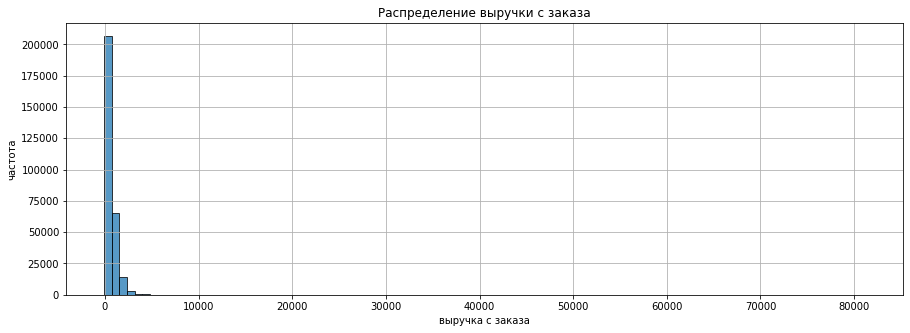

In [25]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 5))

# Строим гистограмму с помощью pandas через plot(kind='hist')
df['revenue_rub'].plot(
                kind='hist', # Тип графика - гистограмма
                bins=100, # Устанавливаем количество корзин - всего 25
                alpha=0.75,
                edgecolor='black',
                rot=0, # Градус вращения подписи по оси Х
)

# Настраиваем оформление графика
plt.title('Распределение выручки с заказа')
plt.xlabel('выручка с заказа')
plt.ylabel('частота')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Обращают на себя внимание отрицательные значения и значения существенно вылетающие за пределы нормы. Гистограмма имеет огромный правый хвост, который наверняка нужно обрубить. Проверим распределение с помощью размаха:

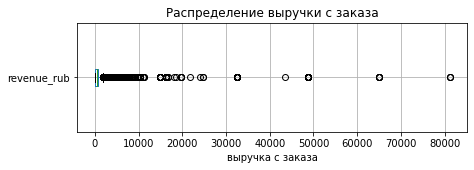

In [26]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 2))

# Строим диаграмму размаха значений в столбце balance
df.boxplot(column='revenue_rub', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение выручки с заказа')
plt.xlabel('выручка с заказа')

# Выводим график
plt.show()

In [27]:
## Чтобы избавиться от этого вылета - проведем фильтрацию
perc_99 = df['revenue_rub'].quantile(0.99)
df = df[df['revenue_rub'] <= perc_99]

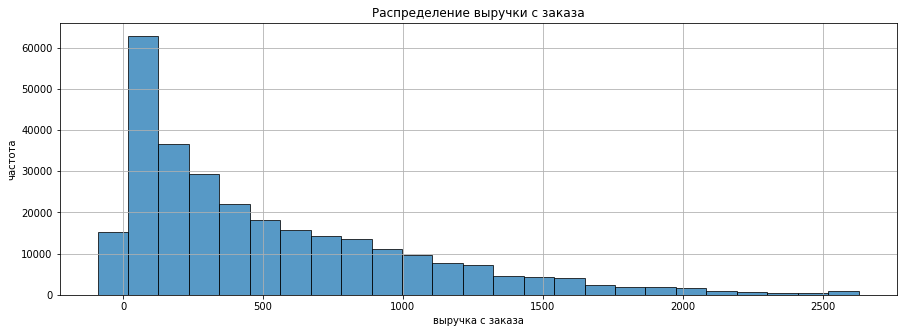

In [28]:
## Проверим результат фильтрации визуально:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 5))

# Строим гистограмму с помощью pandas через plot(kind='hist')
df['revenue_rub'].plot(
                kind='hist', # Тип графика - гистограмма
                bins=25, # Устанавливаем количество корзин - всего 25
                alpha=0.75,
                edgecolor='black',
                rot=0, # Градус вращения подписи по оси Х
)

# Настраиваем оформление графика
plt.title('Распределение выручки с заказа')
plt.xlabel('выручка с заказа')
plt.ylabel('частота')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

___Так гораздо лучше.____

In [29]:
# Изучаем статистические показатели столбца revenue_rub
print('Статистические показатели столбца tickets_count:')
df['tickets_count'].describe()

Статистические показатели столбца tickets_count:


count    287786.000000
mean          2.740495
std           1.163073
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          57.000000
Name: tickets_count, dtype: float64

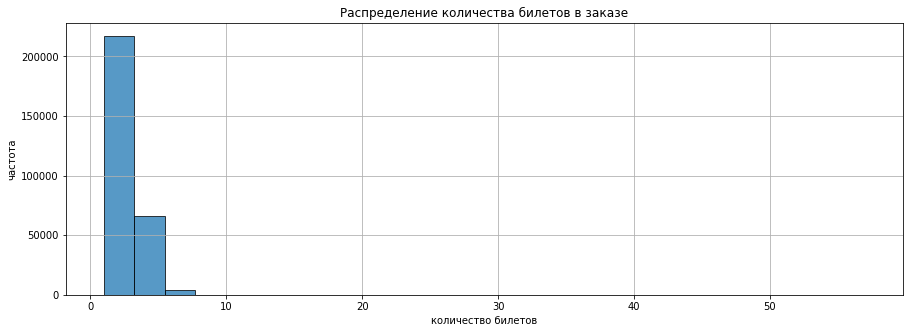

In [30]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 5))

# Строим гистограмму с помощью pandas через plot(kind='hist')
df['tickets_count'].plot(
                kind='hist', # Тип графика - гистограмма
                bins=25, # Устанавливаем количество корзин - всего 25
                alpha=0.75,
                edgecolor='black',
                rot=0, # Градус вращения подписи по оси Х
)

# Настраиваем оформление графика
plt.title('Распределение количества билетов в заказе')
plt.xlabel('количество билетов')
plt.ylabel('частота')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

__Наблюдается явный вылет в 57 билетов в одном заказе. Возможно это был групповой поход, но он будет вносить искажение и не являться релевантным опытом. В связи с чем он также предлагается к исключению.__

In [31]:
## Чтобы избавиться от этого вылета - проведем фильтрацию
perc_99 = df['tickets_count'].quantile(0.99)
df = df[df['tickets_count'] <= perc_99]

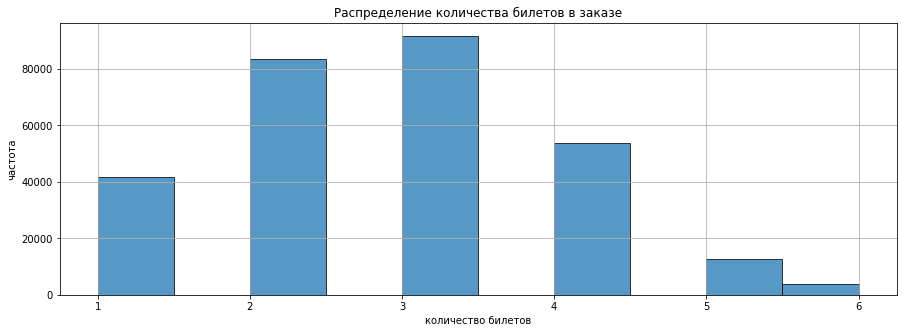

In [32]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 5))

# Строим гистограмму с помощью pandas через plot(kind='hist')
df['tickets_count'].plot(
                kind='hist', # Тип графика - гистограмма
                bins=10, # Устанавливаем количество корзин - всего 25
                alpha=0.75,
                edgecolor='black',
                rot=0, # Градус вращения подписи по оси Х
)

# Настраиваем оформление графика
plt.title('Распределение количества билетов в заказе')
plt.xlabel('количество билетов')
plt.ylabel('частота')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

__После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.__

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287606 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                287606 non-null  object        
 1   device_type_canonical  287606 non-null  object        
 2   order_id               287606 non-null  int64         
 3   order_dt               287606 non-null  datetime64[ns]
 4   order_ts               287606 non-null  datetime64[ns]
 5   currency_code          287606 non-null  object        
 6   revenue                287606 non-null  float64       
 7   tickets_count          287606 non-null  int64         
 8   days_since_prev        265881 non-null  float64       
 9   event_id               287606 non-null  int64         
 10  event_name             287606 non-null  object        
 11  event_type_main        287606 non-null  object        
 12  service_name           287606 non-null  obje

__После проведенных фильтраций мы лишились около 3 тыс. значений. Это составляет чуть более 1% от исходного количества. Так-же на предыдущих шагах при использовании данных о курсах тенге мы получили новый столбец revenue_rub, приводящий все суммы трат к одному знаменателю - стоимости в российских рублях.__

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [34]:
# воспользуемся подсазкой и отсротируем данные по времени совершения заказа: 
df = df.sort_values(by='order_ts')

In [35]:
# Дата первого и последнего заказа
first_last_orders = df.groupby('user_id').agg(
    first_order=('order_ts', 'min'),
    last_order=('order_ts', 'max')
)
print(first_last_orders)

                        first_order          last_order
user_id                                                
0002849b70a3ce2 2024-08-20 16:08:03 2024-08-20 16:08:03
0005ca5e93f2cf4 2024-07-23 18:36:24 2024-10-06 13:56:02
000898990054619 2024-07-13 19:40:48 2024-10-23 15:12:00
00096d1f542ab2b 2024-08-15 16:48:48 2024-08-15 16:48:48
000a55a418c128c 2024-09-29 19:39:12 2024-10-15 10:29:04
...                             ...                 ...
fff13b79bd47d7c 2024-07-16 22:17:10 2024-10-31 18:31:52
fff32fc9ad0f9f6 2024-08-15 14:36:28 2024-10-28 23:40:38
fffcd3dde79eb2c 2024-06-20 19:57:25 2024-10-30 13:37:43
fffeeb3c120cf0b 2024-09-24 10:07:42 2024-09-24 10:07:42
ffff00725179321 2024-09-25 15:12:40 2024-09-25 15:12:40

[21847 rows x 2 columns]


In [36]:
#устройство, с которого был сделан первый заказ; + регион из которого был сделан первый заказ + билетный партнер+ жанр
first_orders = df.drop_duplicates(subset='user_id', keep='first')
first_orders = first_orders[['user_id', 'device_type_canonical','region_name','service_name','event_type_main']]
print(first_orders)

                user_id device_type_canonical                region_name  \
285281  fd4d47438ebb946                mobile         Каменевский регион   
118843  57ef0a1905ac488                mobile           Лесодальний край   
264550  e73089d7d016cd8                mobile        Широковская область   
37413   18e9aead0a393e7                mobile         Каменевский регион   
27124   0e6fa925c5f346f                mobile        Речиновская область   
...                 ...                   ...                        ...   
274000  f0dac51f739f59f                mobile  Солнечнореченская область   
36876   176b51ad2feb561                mobile       Североярская область   
186180  988e4859d820cb5                mobile           Травяная область   
268244  e994c1637905fe5                mobile       Североярская область   
220015  b67477ade5a580d                mobile         Каменевский регион   

          service_name event_type_main  
285281       Прачечная           театр  
11884

In [37]:
users_info = df.groupby('user_id').agg(
    total_order=('order_id', 'count'),  # общее количество заказов;
    avg_revenue=('revenue_rub', 'mean'), # средняя выручка с одного заказа в рублях;
    avg_tickets=('tickets_count', 'mean'), # среднее количество билетов в заказе;
    avg_days_since_prev=('days_since_prev', 'mean') # среднее время между заказами.
)
print(users_info)

                 total_order  avg_revenue  avg_tickets  avg_days_since_prev
user_id                                                                    
0002849b70a3ce2            1  1521.940000     4.000000                  NaN
0005ca5e93f2cf4            2   774.010000     3.000000               75.000
000898990054619            3   767.213333     2.666667               51.000
00096d1f542ab2b            1   917.830000     4.000000                  NaN
000a55a418c128c            2    61.310000     1.500000               16.000
...                      ...          ...          ...                  ...
fff13b79bd47d7c            9   688.043333     2.555556               13.375
fff32fc9ad0f9f6            2   850.995000     2.500000               74.000
fffcd3dde79eb2c           33   557.908485     2.787879                4.125
fffeeb3c120cf0b            1   661.530000     2.000000                  NaN
ffff00725179321            1   802.250000     2.000000                  NaN

[21847 rows

In [38]:
# Соединим информацию в одну таблицу 
users_infos = users_info.merge(first_orders, left_on=['user_id'], right_on=['user_id'], how='left')
print (users_infos)

               user_id  total_order  avg_revenue  avg_tickets  \
0      0002849b70a3ce2            1  1521.940000     4.000000   
1      0005ca5e93f2cf4            2   774.010000     3.000000   
2      000898990054619            3   767.213333     2.666667   
3      00096d1f542ab2b            1   917.830000     4.000000   
4      000a55a418c128c            2    61.310000     1.500000   
...                ...          ...          ...          ...   
21842  fff13b79bd47d7c            9   688.043333     2.555556   
21843  fff32fc9ad0f9f6            2   850.995000     2.500000   
21844  fffcd3dde79eb2c           33   557.908485     2.787879   
21845  fffeeb3c120cf0b            1   661.530000     2.000000   
21846  ffff00725179321            1   802.250000     2.000000   

       avg_days_since_prev device_type_canonical           region_name  \
0                      NaN                mobile    Каменевский регион   
1                   75.000                mobile    Каменевский регион 

In [39]:
users_infos = users_infos.merge(first_last_orders, left_on=['user_id'], right_on=['user_id'], how='left')
print (users_infos)

               user_id  total_order  avg_revenue  avg_tickets  \
0      0002849b70a3ce2            1  1521.940000     4.000000   
1      0005ca5e93f2cf4            2   774.010000     3.000000   
2      000898990054619            3   767.213333     2.666667   
3      00096d1f542ab2b            1   917.830000     4.000000   
4      000a55a418c128c            2    61.310000     1.500000   
...                ...          ...          ...          ...   
21842  fff13b79bd47d7c            9   688.043333     2.555556   
21843  fff32fc9ad0f9f6            2   850.995000     2.500000   
21844  fffcd3dde79eb2c           33   557.908485     2.787879   
21845  fffeeb3c120cf0b            1   661.530000     2.000000   
21846  ffff00725179321            1   802.250000     2.000000   

       avg_days_since_prev device_type_canonical           region_name  \
0                      NaN                mobile    Каменевский регион   
1                   75.000                mobile    Каменевский регион 

In [40]:
# Добавим бинарные признаки
users_infos['is_two'] = users_infos['total_order'].apply(lambda x: 1 if x >= 2 else 0)
users_infos['is_five'] = users_infos['total_order'].apply(lambda x: 1 if x >= 5 else 0)
print (users_infos)

               user_id  total_order  avg_revenue  avg_tickets  \
0      0002849b70a3ce2            1  1521.940000     4.000000   
1      0005ca5e93f2cf4            2   774.010000     3.000000   
2      000898990054619            3   767.213333     2.666667   
3      00096d1f542ab2b            1   917.830000     4.000000   
4      000a55a418c128c            2    61.310000     1.500000   
...                ...          ...          ...          ...   
21842  fff13b79bd47d7c            9   688.043333     2.555556   
21843  fff32fc9ad0f9f6            2   850.995000     2.500000   
21844  fffcd3dde79eb2c           33   557.908485     2.787879   
21845  fffeeb3c120cf0b            1   661.530000     2.000000   
21846  ffff00725179321            1   802.250000     2.000000   

       avg_days_since_prev device_type_canonical           region_name  \
0                      NaN                mobile    Каменевский регион   
1                   75.000                mobile    Каменевский регион 

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке; __21847 строк - соответствует 21847 пользователям (без учета того, что пользователь мог зарегистрироваться дважды)__
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [41]:
# среднюю выручку с одного заказа
avg_rev = users_infos['avg_revenue'].mean()
print(avg_rev) 


544.1610668323726


In [42]:
# долю пользователей, совершивших 2 и более заказа 
percent_is_two=users_infos['is_two'].mean()
print(percent_is_two)
#Использование арифметического среднего - оправданно, поскольку применение 
# арифмтеичского среднего к бинарному распределению даст - долю единиц в общем массиве

0.6170183549228727


In [43]:
# долю пользователей, совершивших 5 и более заказа 
percent_is_five=users_infos['is_five'].mean()
print(percent_is_five)

0.29006270883874213


In [44]:
# Изучаем статистические показатели столбцов total_order, avg_tickets, avg_days_since_prev
print('Статистические показатели столбца total_order:')
users_infos['total_order'].describe()


Статистические показатели столбца total_order:


count    21847.000000
mean        13.164553
std        121.581813
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10168.000000
Name: total_order, dtype: float64

__имеется явное отклонение по количеству покупок__

In [45]:
print('Статистические показатели столбца avg_tickets:')
users_infos['avg_tickets'].describe()


Статистические показатели столбца avg_tickets:


count    21847.000000
mean         2.739164
std          0.902689
min          1.000000
25%          2.000000
50%          2.750000
75%          3.071429
max          6.000000
Name: avg_tickets, dtype: float64

In [46]:
print('Статистические показатели столбца avg_days_since_prev:')
users_infos['avg_days_since_prev'].describe()

Статистические показатели столбца avg_days_since_prev:


count    13509.000000
mean        15.837199
std         22.289646
min          0.000000
25%          1.000000
50%          8.000000
75%         20.333333
max        148.000000
Name: avg_days_since_prev, dtype: float64

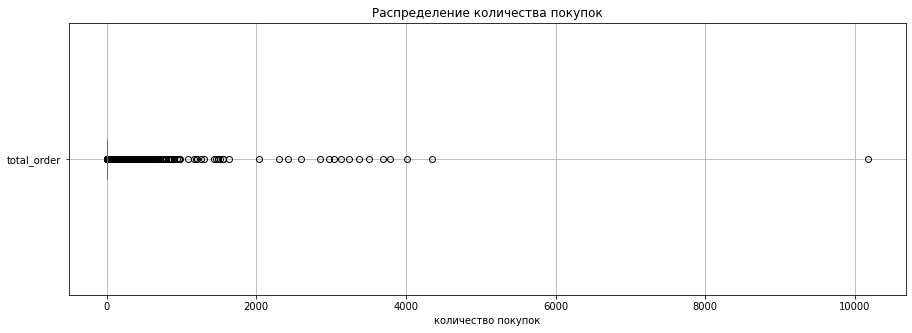

In [47]:
#Проанализируем размах в столбце с данными о количестве покупок пользователями 
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 5))

# Строим диаграмму размаха значений в столбце balance
users_infos.boxplot(column='total_order', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение количества покупок')
plt.xlabel('количество покупок')

# Выводим график
plt.show()

__На мой взгляд, если по итогу нам нужно будет найти взаимосвязи между имеющейся статистикой по количеству покупок и любой другой характеристикой, то подобный разброс всегда будет вносить искажение данных поскольку имеется слишком большой диапазон отсутсвия освещенности данными в интервале от 1800 до примерно 10000. Это чревато тем, что могут появляться зависимости там, где их быть не должно поскольку хвост зависимости всегда будет вытягиваться в сторону наибольших значений, но при этом также это может губить зависимости там, где они могут быть по причине искажения влияния на второе изучаемое свойство (при его малой представительности). Я считаю необходимым проиpвести исключение данных вызодящих за 99 перцентиль количества покупок.__

In [48]:
perc_99 = users_infos['total_order'].quantile(0.99)
users_infos_filtred = users_infos[users_infos['total_order'] <= perc_99]


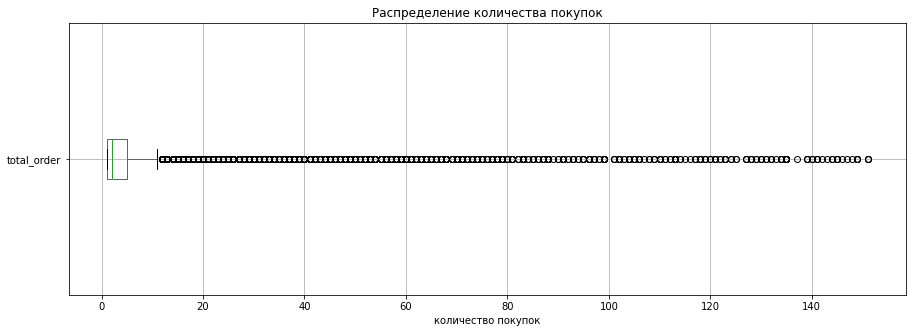

In [49]:
#Проанализируем размах в столбце с данными о количестве покупок пользователями 
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 5))

# Строим диаграмму размаха значений в столбце balance
users_infos_filtred.boxplot(column='total_order', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение количества покупок')
plt.xlabel('количество покупок')

# Выводим график
plt.show()

In [50]:
users_infos_filtred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21628 entries, 0 to 21846
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                21628 non-null  object        
 1   total_order            21628 non-null  int64         
 2   avg_revenue            21628 non-null  float64       
 3   avg_tickets            21628 non-null  float64       
 4   avg_days_since_prev    13290 non-null  float64       
 5   device_type_canonical  21628 non-null  object        
 6   region_name            21628 non-null  object        
 7   service_name           21628 non-null  object        
 8   event_type_main        21628 non-null  object        
 9   first_order            21628 non-null  datetime64[ns]
 10  last_order             21628 non-null  datetime64[ns]
 11  is_two                 21628 non-null  int64         
 12  is_five                21628 non-null  int64         
dtypes

__Было исключено порядка 220 строчек данных что составило примерно 1 %__

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


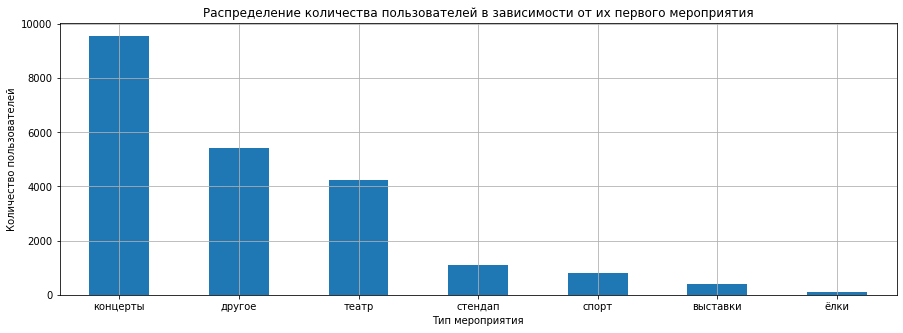

In [51]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 5))
# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
users_infos_filtred['event_type_main'].value_counts().plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение количества пользователей в зависимости от их первого мероприятия'
)

# Настраиваем оформление графика
plt.xlabel('Тип мероприятия')
plt.ylabel('Количество пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

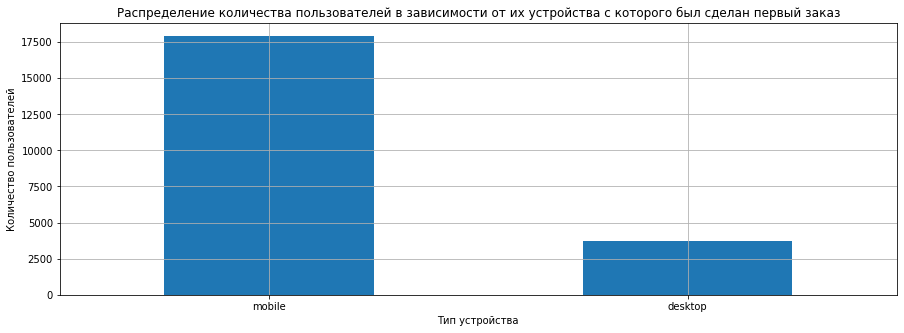

In [52]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 5))
# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
users_infos_filtred['device_type_canonical'].value_counts().plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение количества пользователей в зависимости от их устройства с которого был сделан первый заказ'
)

# Настраиваем оформление графика
plt.xlabel('Тип устройства')
plt.ylabel('Количество пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

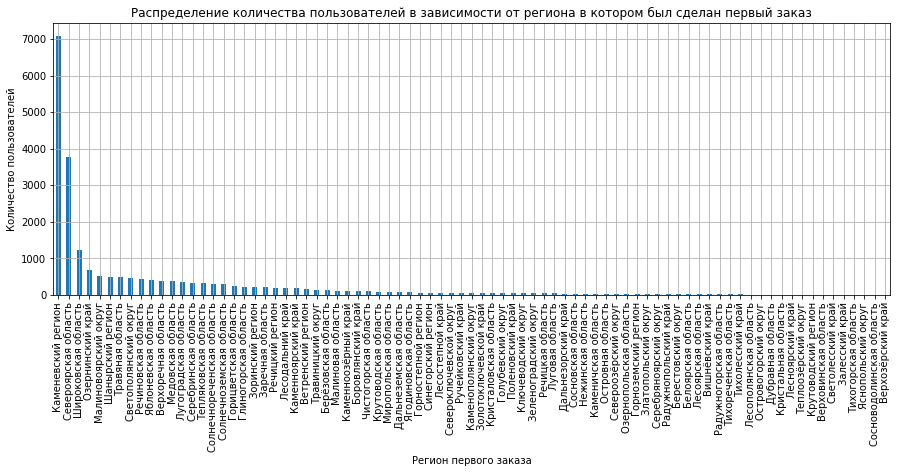

In [53]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 5))
# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
users_infos_filtred['region_name'].value_counts().plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=90, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение количества пользователей в зависимости от региона в котором был сделан первый заказ'
)

# Настраиваем оформление графика
plt.xlabel('Регион первого заказа')
plt.ylabel('Количество пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

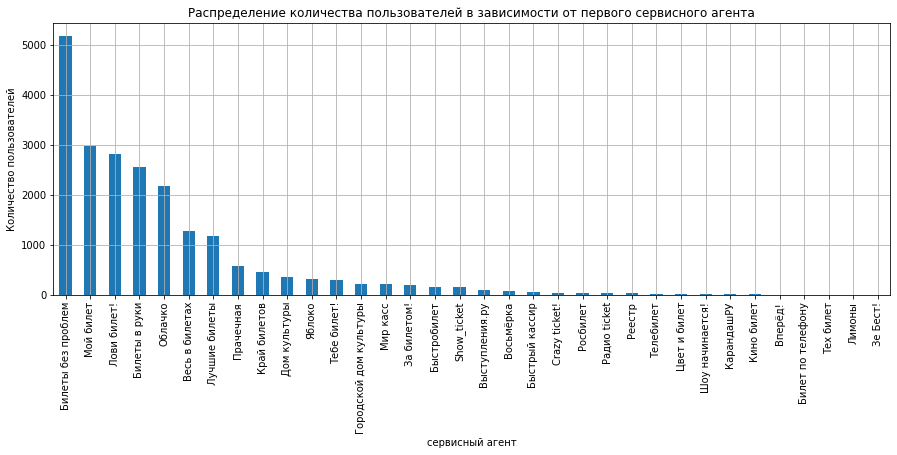

In [54]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 5))
# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
users_infos_filtred['service_name'].value_counts().plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=90, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение количества пользователей в зависимости от первого сервисного агента'
)

# Настраиваем оформление графика
plt.xlabel('сервисный агент')
plt.ylabel('Количество пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

__Лучше всего со всеми подзадачами задачи 4.1.1 справляется гистограмма. Лидируют сегменты: Концерты, Mobile, Каменевский регион, Билеты без проблем.__

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [55]:
#Для сегмента первого мероприятия вычисляем долю пользователей, совершивших два и более заказа
event = users_infos_filtred.groupby(['event_type_main']).agg({'is_two': 'mean'}).sort_values(by='is_two', ascending=False)

print (event)

                   is_two
event_type_main          
выставки         0.640097
театр            0.633876
концерты         0.618226
стендап          0.609009
другое           0.595792
спорт            0.557935
ёлки             0.557895


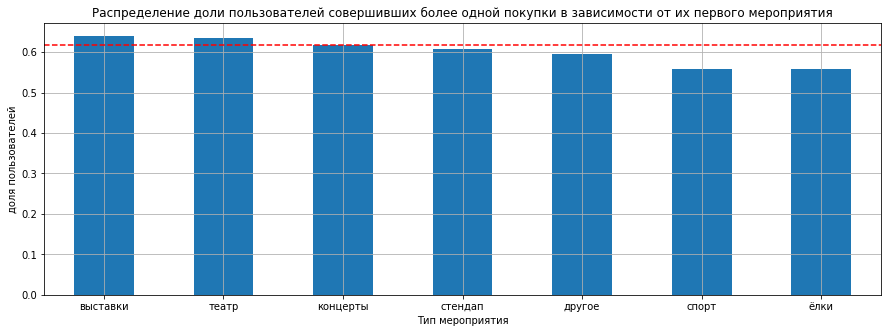

In [56]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 5))
# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
event['is_two'].plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение доли пользователей совершивших более одной покупки в зависимости от их первого мероприятия'
)
plt.axhline(y=0.617, color='red', linestyle='--', label='Среднее значение')
# Настраиваем оформление графика
plt.xlabel('Тип мероприятия')
plt.ylabel('доля пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

In [57]:
#Для сегмента первого устройства вычисляем долю пользователей, совершивших два и более заказа
device = users_infos_filtred.groupby(['device_type_canonical']).agg({'is_two': 'mean'}).sort_values(by='is_two', ascending=False)

print (device)

                         is_two
device_type_canonical          
desktop                0.638177
mobile                 0.607958


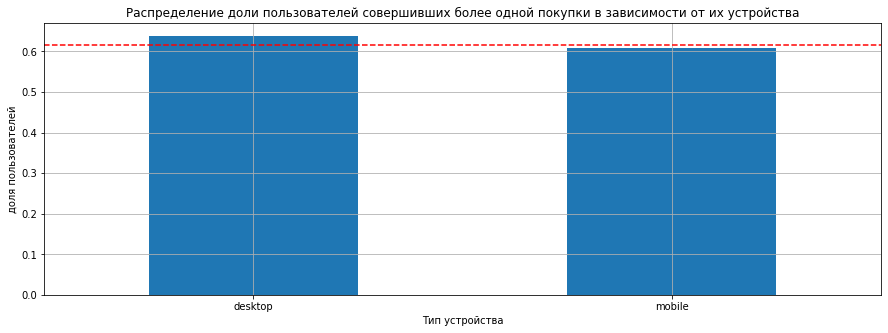

In [58]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 5))
# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
device['is_two'].plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение доли пользователей совершивших более одной покупки в зависимости от их устройства'
)

# Настраиваем оформление графика
plt.axhline(y=0.617, color='red', linestyle='--', label='Среднее значение')
plt.xlabel('Тип устройства')
plt.ylabel('доля пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

In [59]:
# Отфильтруем первые 10 регионов по количеству пользователей
region = users_infos_filtred.groupby(['region_name']).agg({'is_two': ['count', 'mean']})
sorted_regions = region.sort_values(by=('is_two', 'count'), ascending=False)
top_10_regions = sorted_regions.head(10).sort_values(by=('is_two', 'mean'), ascending=False)
print(top_10_regions)


                     is_two          
                      count      mean
region_name                          
Шанырский регион        500  0.672000
Светополянский округ    457  0.656455
Широковская область    1225  0.645714
Североярская область   3759  0.637404
Речиновская область     440  0.634091
Каменевский регион     7085  0.623994
Травяная область        488  0.614754
Яблоневская область     411  0.593674
Малиновоярский округ    525  0.560000
Озернинский край        675  0.552593


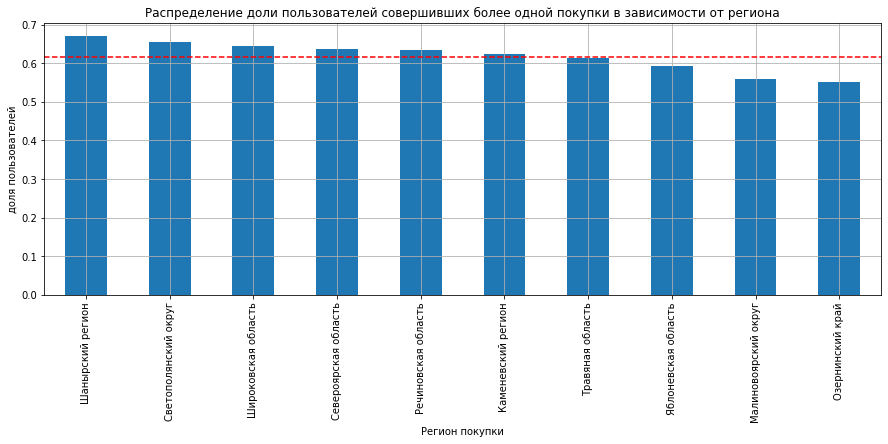

In [60]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 5))
# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
top_10_regions['is_two', 'mean'].plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=90, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение доли пользователей совершивших более одной покупки в зависимости от региона'
)

# Настраиваем оформление графика
plt.axhline(y=0.617, color='red', linestyle='--', label='Среднее значение')

plt.xlabel('Регион покупки')
plt.ylabel('доля пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

In [61]:
# Отфильтруем первые 10 сервисов по количеству пользователей
service = users_infos_filtred.groupby(['service_name']).agg({'is_two': ['count', 'mean']})
sorted_service = service.sort_values(by=('is_two', 'count'), ascending=False)
top_10_service = sorted_service.head(10).sort_values(by=('is_two', 'mean'), ascending=False)



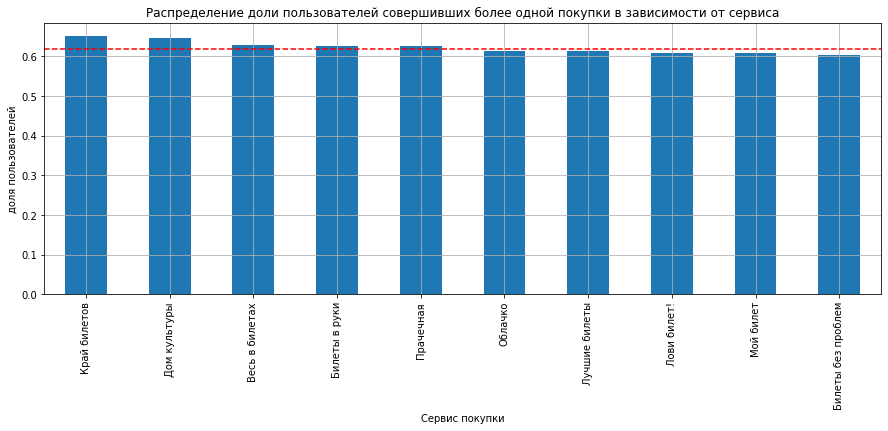

In [62]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 5))
# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
top_10_service['is_two', 'mean'].plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=90, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение доли пользователей совершивших более одной покупки в зависимости от сервиса'
)

# Настраиваем оформление графика
plt.axhline(y=0.617, color='red', linestyle='--', label='Среднее значение')
plt.xlabel('Сервис покупки')
plt.ylabel('доля пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

__Точки входа - Выставки и театры; Компьютер;Шанырский регион, Светополянский округ, Широковская область; Сервисы: Край билетов, Дом культуры и Весь в билетах.__

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты. __Да, действительно подобная зависимость имеется, вот только те кто впервые заказали билеты на спортивные мероприятия - наоборот делают повторные заказы реже чем например те, кто сделал первый заказ на выставки.__
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах. __В явном виде - гипотеза не подтверждается, наиболее популярный регион по посещаемости мероприятий - Каменевский, но по количеству повторных заказов он вне первой пятерки.__

---

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


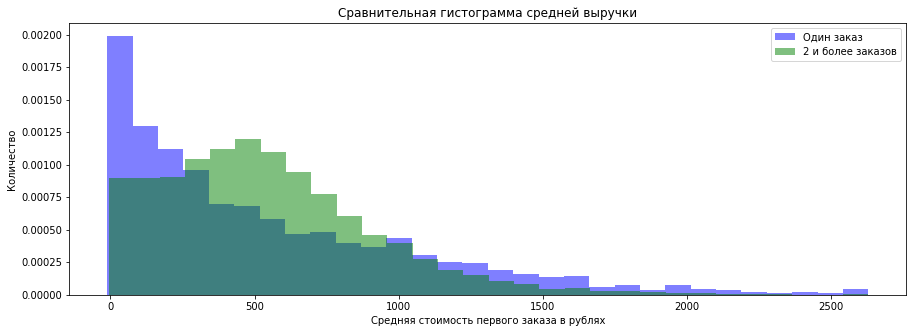

In [64]:
one_order = users_infos_filtred[users_infos_filtred['is_two'] == 0]['avg_revenue']
multiple_orders = users_infos_filtred[users_infos_filtred['is_two'] == 1]['avg_revenue']

# Создание гистограмм
plt.figure(figsize=(15, 5))
plt.hist(one_order, bins=30, color='blue', alpha=0.5, label='Один заказ', density=True)
plt.hist(multiple_orders, bins=30, color='green', alpha=0.5, label='2 и более заказов', density=True)
plt.title('Сравнительная гистограмма средней выручки')
plt.xlabel('Средняя стоимость первого заказа в рублях')
plt.ylabel('Количество')
plt.legend()

plt.show()

__пользователи совершившие один заказ концентрируются в стоимости заказа порядка 100 рублей. Пользователи совершившие 2 и более заказов концентрируются в области более высоких стоимостей заказа - порядка 500 рублей. Зависимости сильно отличаются вероятно первая покупка, на более дорогое (качественное) мероприятие оставила более лучшие впечатления и пользователь захотел сделать повторный заказ.__

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [65]:
#Отфильтруем пользователей с одной покупкой
u_filtred = users_infos_filtred[users_infos_filtred['is_two'] == 1]


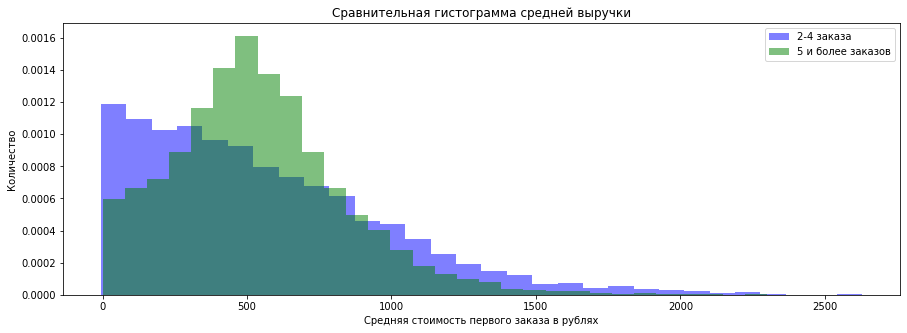

In [66]:
btw2_4_order = u_filtred[u_filtred['is_five'] == 0]['avg_revenue']
more_order = u_filtred[u_filtred['is_five'] == 1]['avg_revenue']

# Создание гистограмм
plt.figure(figsize=(15, 5))
plt.hist(btw2_4_order, bins=30, color='blue', alpha=0.5, label='2-4 заказа', density=True)
plt.hist(more_order, bins=30, color='green', alpha=0.5, label='5 и более заказов', density=True)
plt.title('Сравнительная гистограмма средней выручки')
plt.xlabel('Средняя стоимость первого заказа в рублях')
plt.ylabel('Количество')
plt.legend()

plt.show()

__Да, различие по значению средней выручки с заказа сохраняется, но различие стало менее выраженным, а распределение группы с меньшим количеством заказов - более равномерное.__

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [67]:
bins = [1, 2, 3, 5, float('inf')]  # Границы промежутков
labels = ['от 1 до 2 билетов', 'от 2 до 3 билетов', 'от 3 до 5 билетов', 'от 5 и более билетов']

# Группировка данных
users_infos_filtred['segment'] = pd.cut(users_infos_filtred['avg_tickets'], bins=bins, labels=labels)

# Подсчёт общего числа пользователей в каждом сегменте
segment_counts = users_infos_filtred['segment'].value_counts()

# Пример подсчёта доли пользователей, совершивших повторные заказы

repeated_orders_ratio = (users_infos_filtred[users_infos_filtred['is_two'] == 1]['segment'].value_counts() / segment_counts)

print("Общее число пользователей в каждом сегменте:")
print(segment_counts)
print("\nДоля пользователей, совершивших повторные заказы:")
print(repeated_orders_ratio)

Общее число пользователей в каждом сегменте:
от 2 до 3 билетов       9941
от 3 до 5 билетов       5345
от 1 до 2 билетов       4825
от 5 и более билетов     179
Name: segment, dtype: int64

Доля пользователей, совершивших повторные заказы:
от 2 до 3 билетов       0.742682
от 3 до 5 билетов       0.626380
от 1 до 2 билетов       0.480000
от 5 и более билетов    0.301676
Name: segment, dtype: float64


/tmp/ipykernel_48/3788365137.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_infos_filtred['segment'] = pd.cut(users_infos_filtred['avg_tickets'], bins=bins, labels=labels)


__Пользователи сконцентрированы среди тех, кто купил от 2 до 3 билетов, также доля ползователей совершивших повторные заказы - наиболее высокая по пользователям купившим от 2 до 3 билетов. Таже наблюдаются пользователи с аномально низкой повторной покупкой - эти пользователи купили 5 и более билетов в первый раз.__


---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [68]:
users_infos_filtred['day_of_week'] = users_infos_filtred['first_order'].dt.day_name()

print(users_infos_filtred[['first_order', 'day_of_week']])

              first_order day_of_week
0     2024-08-20 16:08:03     Tuesday
1     2024-07-23 18:36:24     Tuesday
2     2024-07-13 19:40:48    Saturday
3     2024-08-15 16:48:48    Thursday
4     2024-09-29 19:39:12      Sunday
...                   ...         ...
21842 2024-07-16 22:17:10     Tuesday
21843 2024-08-15 14:36:28    Thursday
21844 2024-06-20 19:57:25    Thursday
21845 2024-09-24 10:07:42     Tuesday
21846 2024-09-25 15:12:40   Wednesday

[21628 rows x 2 columns]


/tmp/ipykernel_48/2182474729.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_infos_filtred['day_of_week'] = users_infos_filtred['first_order'].dt.day_name()


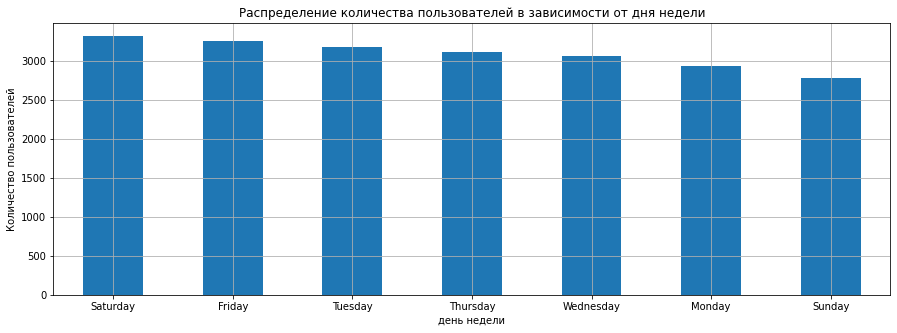

In [69]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 5))
# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
users_infos_filtred['day_of_week'].value_counts().plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение количества пользователей в зависимости от дня недели'
)

# Настраиваем оформление графика
plt.xlabel('день недели')
plt.ylabel('Количество пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

In [70]:
#Для сегмента дня недели вычисляем долю пользователей, совершивших два и более заказа
week_day = users_infos_filtred.groupby(['day_of_week']).agg({'is_two': 'mean'}).sort_values(by='is_two', ascending=False)

print (week_day)

               is_two
day_of_week          
Monday       0.630249
Saturday     0.628012
Wednesday    0.621524
Tuesday      0.618508
Sunday       0.600360
Friday       0.598220
Thursday     0.594473


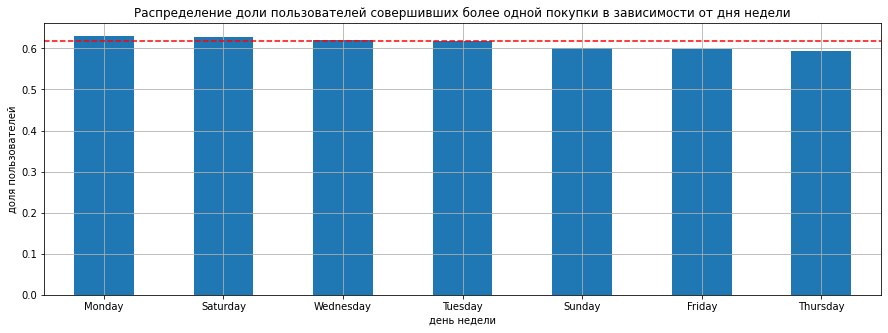

In [71]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 5))
# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
week_day['is_two'].plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение доли пользователей совершивших более одной покупки в зависимости от дня недели'
)

# Настраиваем оформление графика
plt.axhline(y=0.617, color='red', linestyle='--', label='Среднее значение')
plt.xlabel('день недели')
plt.ylabel('доля пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

__Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?__
- Да влияние есть. Люди сделавшие первый заказ в понедельние и суббот - чаще чем остальные поккупали повторно билеты. А люди купившие первый билет в пятницу или вторник - наоборот - реже.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


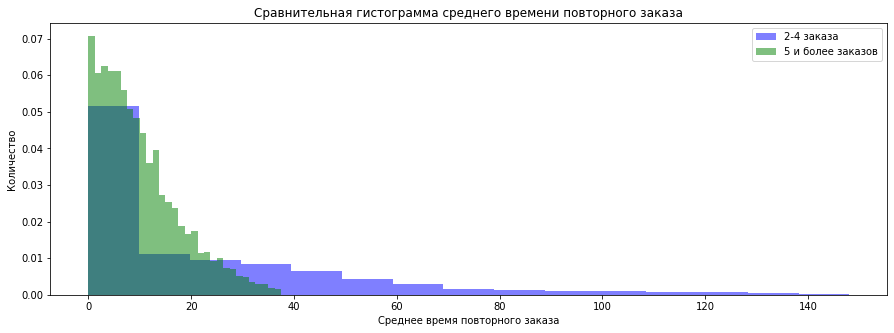

In [72]:
btw2_4_order = u_filtred[u_filtred['is_five'] == 0]['avg_days_since_prev']
more_order = u_filtred[u_filtred['is_five'] == 1]['avg_days_since_prev']

# Создание гистограмм
plt.figure(figsize=(15, 5))
plt.hist(btw2_4_order, bins=15, color='blue', alpha=0.5, label='2-4 заказа', density=True)
plt.hist(more_order, bins=30, color='green', alpha=0.5, label='5 и более заказов', density=True)
plt.title('Сравнительная гистограмма среднего времени повторного заказа')
plt.xlabel('Среднее время повторного заказа')
plt.ylabel('Количество')
plt.legend()

plt.show()

__Оба распределения пусть и с разной детальностью показывают, что повторный заказ чаще всего осуществлялся в течении 10 дней__

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [73]:
segments = pd.cut(users_infos_filtred['total_order'], bins=[0, 1, 4, float('inf')], labels=['1 заказ', 'от 2 до 4 заказов', 'от 5 и выше'])
users_infos_filtred['segment'] = segments
users_infos_filtred.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21628 entries, 0 to 21846
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                21628 non-null  object        
 1   total_order            21628 non-null  int64         
 2   avg_revenue            21628 non-null  float64       
 3   avg_tickets            21628 non-null  float64       
 4   avg_days_since_prev    13290 non-null  float64       
 5   device_type_canonical  21628 non-null  object        
 6   region_name            21628 non-null  object        
 7   service_name           21628 non-null  object        
 8   event_type_main        21628 non-null  object        
 9   first_order            21628 non-null  datetime64[ns]
 10  last_order             21628 non-null  datetime64[ns]
 11  is_two                 21628 non-null  int64         
 12  is_five                21628 non-null  int64         
 13  s

/tmp/ipykernel_48/2249506736.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_infos_filtred['segment'] = segments


In [78]:
interval_columns = ['avg_revenue', 'avg_tickets', 'avg_days_since_prev']
correlation_matrix = users_infos_filtred[interval_columns + ['device_type_canonical', 'region_name', 'service_name', 'event_type_main', 'segment']].phik_matrix()

# Выводим результат
print('Корреляционная матрица с коэффициентом phi_k для переменной rating')
correlation_matrix.loc[correlation_matrix.index != 'segment'][['segment']].sort_values(by='segment', ascending=False)


interval columns not set, guessing: ['avg_revenue', 'avg_tickets', 'avg_days_since_prev']
Корреляционная матрица с коэффициентом phi_k для переменной rating


,segment
avg_tickets,0.584591
avg_days_since_prev,0.391067
avg_revenue,0.325685
region_name,0.123252
service_name,0.081081
event_type_main,0.040945
device_type_canonical,0.017262


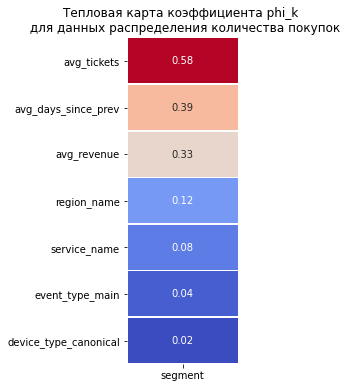

In [79]:
# Строим тепловую карту
plt.figure(figsize=(2, 6))

# Сохраняем матрицу корреляции рейтинга с другими показателями
data_heatmap = correlation_matrix.loc[correlation_matrix.index != 'segment'][['segment']].sort_values(by='segment', ascending=False)
sns.heatmap(data_heatmap,
            annot=True, # Отображаем численные значения в ячейках карты
            fmt='.2f', # Форматируем значения корреляции: два знака после точки
            cmap='coolwarm', # Устанавливаем цветовую гамму от красного (макс. значение) к синему
            linewidths=0.5, # Форматируем линию между ячейками карты
            cbar=False # Отключаем цветовую шкалу
           )

# Добавляем заголовок и подпись по оси Х
plt.title('Тепловая карта коэффициента phi_k \n для данных распределения количества покупок')
plt.xlabel('')

# Выводим график
plt.show()

__Наибольшая зависимость имеется с показателем среднего количесва купленных билетов далее с показателем времени между покупками.__

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

__Информация о данных:__

- Всего 290611 строк данных в 15 столбцах.Пропусков в загруженных данных практически - нет, поскольку мы ранее использовали тип присоединения inner join. в столбце days_since_prev имеются отсутвующие значения, но это было сделано намеренно, значит это были первые заказы. Все типы данных соответствуют хранящимся данным хранимым в стобцах. Названия столбцов соответствует стилистике змеиного языка. 
- Средни покупок был те, что совершены в тенге а не рублях. Для перевода их в рубли была использована информация о курсе на кажду из дат покупки.
- Последовательно были отфильтрованные вылетающие данные - сначала по выручки с покупки, потом по количеству билетов и данные выходящие за пределы 99 перцентиля количества покупок, поскольку они могли повлиять на последующий анализ. Было исключено порядка 1 % от изначальных данных.

__Основные результаты анализа:__

-Всего было 21847 пользователей. В среднем порядка 61.7% пользователей совершали более одного заказа. Входе рассмотрения гипотезы было выяснено, что те кто впервые заказали билеты на спортивные мероприятия - наоборот делают повторные заказы реже чем например те, кто сделал первый заказ на выставки.

-Наибольшая зависимость имеется с показателем среднего количесва купленных билетов далее с показателем времени между покупками.

Какие признаки первого заказа связаны с возвратом пользователей?

- Было отмечено, что если стоимость первого заказа была ближе к 500 рубля, то вероятность повторного заказа была выше чем если стоимость первого заказа была ниже. На основании  корреляционного анализа обнаружена сильная связь между параметром количества покупок и средним количеством купленных билетов.
- Было отмечено, что если пользователь делает свою первую покупку в понедельник или субботу он с большей вероятностью сделает ее еще раз. Также было отмечено, что чаще всего пользователь делает свою повторную покупку на десятый день после первой.
- Согласно результатам корреляционного анализа с числом покупок связаны среднее количество купленных билетов, средняя продолжительность до повторной покупкой и средняя стоимость первой покупки.


- Для увеличения количества повторных покупок рекомендуется ближе к 8-9 дню после первой покупи начинать делать выгодные предложения для клиента в ценовой категории - порядка 500 рублей, также на возможность повторных покупок положительно скажется возможность бонусных условия за покупку более одного билета. Наблюдается просадка по посетителям стендапов, спортивных меорприятий выставок и ёлок это потенциальные области для роста. 

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**